# Simulation - varying DA challenges probability

#### Maria Silva, February 2024

## Load & imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
code_dir = os.path.realpath(os.path.join(os.getcwd(), ".."))

import sys
sys.path.append(code_dir)

In [3]:
from redsim.params import Params
from redsim.sim import run_mc_sim

## Set paramaters

In [4]:
sim_len = int(30 * 60 * 60 * 24 / 12)  # 30 day of ETH blocks
sim_iter = 1000  # MC paths

params = Params()
params.set_default_params()

da_chalenge_p_list = [0.0007, 0.007, 0.07] # 5, 50, and 500 per day

## Run full MC simulation

In [5]:
sim_df = pd.DataFrame()

for da_chalenge_p in da_chalenge_p_list:
    params.set_param("da_chalenge_p", da_chalenge_p)
    temp_df = run_mc_sim(sim_len, sim_iter, params, agg_daily = True)
    temp_df["da_chalenge_p"] = da_chalenge_p
    sim_df = pd.concat([sim_df, temp_df], ignore_index=True)
    
sim_df.to_csv("../data/sim_da_params_output.csv", index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:46<00:00,  6.02it/s]


## Analyse results

In [6]:
sim_df = pd.read_csv("../data/sim_da_params_output.csv")
sim_df["da_chalenge_p"] = sim_df["da_chalenge_p"].astype("str")
sim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              90000 non-null  object 
 1   onchain_profit_eth     90000 non-null  float64
 2   onchain_profit_usd     90000 non-null  float64
 3   total_profit_eth       90000 non-null  float64
 4   total_profit_usd       90000 non-null  float64
 5   op_rev_share_cost_eth  90000 non-null  float64
 6   l1_base_fee_gwei       90000 non-null  float64
 7   l1_prio_fee_gwei       90000 non-null  float64
 8   l2_base_fee_gwei       90000 non-null  float64
 9   l2_prio_fee_gwei       90000 non-null  float64
 10  l2_gas                 90000 non-null  float64
 11  da_challenge           90000 non-null  float64
 12  infra_cost_usd         90000 non-null  float64
 13  revenue_eth            90000 non-null  float64
 14  revenue_data_eth       90000 non-null  float64
 15  re

In [7]:
temp_df = (
    sim_df[sim_df["timestamp"]==sim_df["timestamp"].max()] # get last day of sim
    .groupby("da_chalenge_p")
    [["onchain_profit_eth", "total_profit_eth", "op_rev_share_cost_eth", "onchain_profit_usd", "total_profit_usd"]]
    .agg(["mean", "std"])
    .round(2)
)
temp_df

onchain_profit_eth       total_profit_eth        \
                            mean   std             mean   std   
da_chalenge_p                                                   
0.0007                     78.18  0.49            62.39  0.41   
0.007                      74.56  0.59            59.32  0.50   
0.07                       38.29  1.08            28.49  0.92   

              op_rev_share_cost_eth       onchain_profit_usd           \
                               mean   std               mean      std   
da_chalenge_p                                                           
0.0007                        11.73  0.07          195451.24  1213.25   
0.007                         11.18  0.09          186408.42  1468.97   
0.07                           5.74  0.16           95732.52  2705.70   

              total_profit_usd           
                          mean      std  
da_chalenge_p                            
0.0007               155981.58  1031.44  
0.007                148294.77  1248.55  
0.07                  71220.62  2299.78

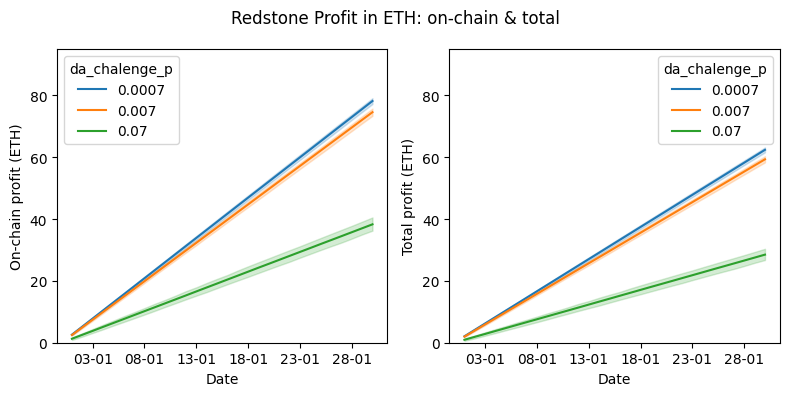

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
sns.lineplot(data=sim_df, x="timestamp", y="onchain_profit_eth", hue="da_chalenge_p", errorbar="pi", ax=axs[0])
axs[0].set_xlabel("Date") 
axs[0].set_ylabel("On-chain profit (ETH)") 
axs[0].set_ylim(0,95)
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=5))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
sns.lineplot(data=sim_df, x="timestamp", y="total_profit_eth",hue="da_chalenge_p", errorbar="pi", ax=axs[1])
axs[1].set_xlabel("Date") 
axs[1].set_ylabel("Total profit (ETH)") 
axs[1].set_ylim(0,95)
plt.suptitle("Redstone Profit in ETH: on-chain & total")
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval=5))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.tight_layout()
plt.show()

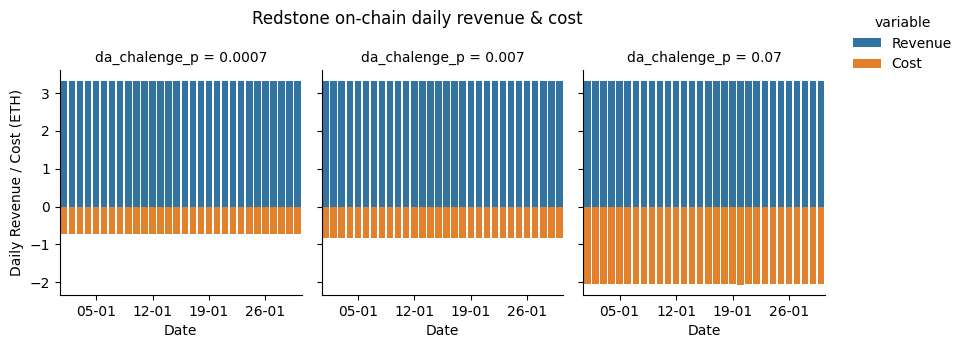

In [9]:
temp_df = sim_df.copy()
temp_df["Revenue"] = temp_df["revenue_eth"]
temp_df["Cost"] = -temp_df["onchain_cost_eth"]
temp_df = temp_df.melt(id_vars=["timestamp", "da_chalenge_p"], value_vars=["Revenue", "Cost"])

g = sns.catplot(data=temp_df, x="timestamp", y="value", hue="variable", col="da_chalenge_p", 
                kind="bar", height=3.5, aspect=0.7, estimator="mean", errorbar=None, dodge=False)
g.set(xlabel="Date", ylabel="Daily Revenue / Cost (ETH)")
for ax in g.axes[0]:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.suptitle("Redstone on-chain daily revenue & cost")
plt.tight_layout()
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [10]:
temp_df = (
    sim_df
    .groupby("da_chalenge_p")
    [["revenue_data_eth", "revenue_exec_eth", "batcher_gas_cost_eth", "proposer_gas_cost_eth", "da_gas_cost_eth"]]
    .agg(["mean", "std"])
    .round(3)
)
temp_df

revenue_data_eth        revenue_exec_eth         \
                          mean    std             mean    std   
da_chalenge_p                                                   
0.0007                   3.256  0.095            0.066  0.003   
0.007                    3.257  0.095            0.066  0.003   
0.07                     3.256  0.096            0.066  0.003   

              batcher_gas_cost_eth        proposer_gas_cost_eth         \
                              mean    std                  mean    std   
da_chalenge_p                                                            
0.0007                       0.644  0.014                 0.059  0.007   
0.007                        0.644  0.014                 0.059  0.007   
0.07                         0.644  0.014                 0.059  0.007   

              da_gas_cost_eth         
                         mean    std  
da_chalenge_p                         
0.0007                  0.013  0.019  
0.007                   0.135  0.060  
0.07                    1.343  0.184

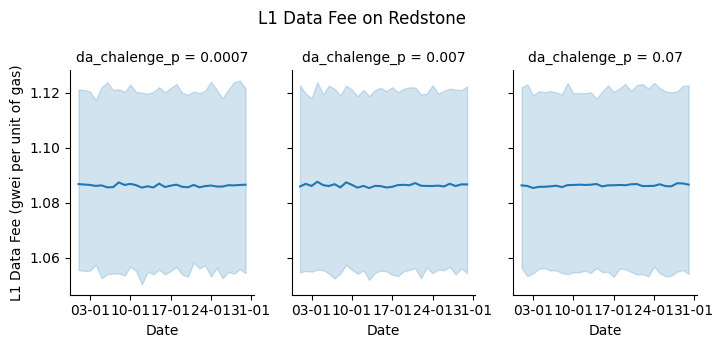

In [11]:
temp_df = sim_df.copy()
temp_df["l1_data_fee_cost"] = temp_df["revenue_data_eth"] / temp_df["l2_gas"]
temp_df["l1_data_fee_cost_gwei"] = temp_df["l1_data_fee_cost"]/0.000000001

g = sns.relplot(data=temp_df, x="timestamp", y="l1_data_fee_cost_gwei", col="da_chalenge_p", 
                kind="line", height=3.5, aspect=0.7, errorbar="pi")
g.set(xlabel="Date", ylabel="L1 Data Fee (gwei per unit of gas)")
for ax in g.axes[0]:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.suptitle("L1 Data Fee on Redstone")
plt.tight_layout()
plt.show()

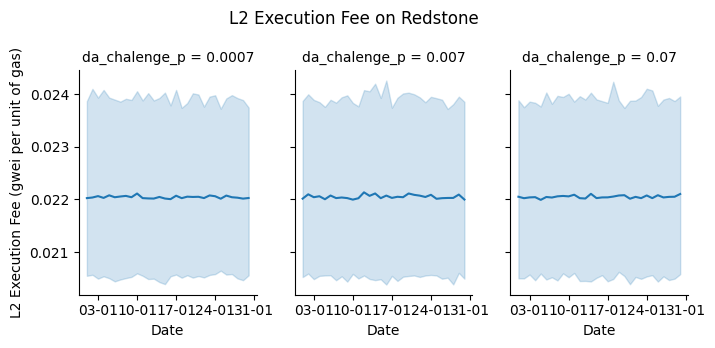

In [12]:
temp_df = sim_df.copy()
temp_df["exec_fee_cost"] = temp_df["revenue_exec_eth"] / temp_df["l2_gas"]
temp_df["exec_fee_cost_gwei"] = temp_df["exec_fee_cost"]/0.000000001

g = sns.relplot(data=temp_df, x="timestamp", y="exec_fee_cost_gwei", col="da_chalenge_p", 
                kind="line", height=3.5, aspect=0.7, errorbar="pi")
g.set(xlabel="Date", ylabel="L2 Execution Fee (gwei per unit of gas)")
for ax in g.axes[0]:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.suptitle("L2 Execution Fee on Redstone")
plt.tight_layout()
plt.show()